# Creating Fishnet / Gridded Polygons

<b> This notebook will guide you to create fishnet/gridded polygons of dynamic length using GeoPandas in Python.

In [1]:
import warnings
warnings.filterwarnings('ignore')

<b> Importing necessary dependencies

In [2]:
import shapely
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geopandas import GeoDataFrame
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt
import seaborn as sns
from tqdm import tqdm
from pyproj import Geod
geod = Geod(ellps="WGS84")


from shapely import wkt
from tqdm.notebook import tqdm
tqdm.pandas()

from matplotlib import rc, rcParams
rc('font', weight='bold')

In [3]:
from pyproj import Geod
from shapely import wkt

geod = Geod(ellps="WGS84")

# Loading shape files

In [4]:
# importing global map using geopandas

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<AxesSubplot: >

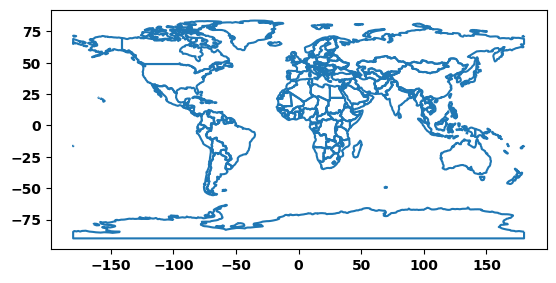

In [5]:
world.geometry.boundary.plot()

In [16]:
# selecting map of Nepal only, as it's size is relatively small and it will be easier to perform gridding

area = world[world.name == 'Nepal']

<AxesSubplot: >

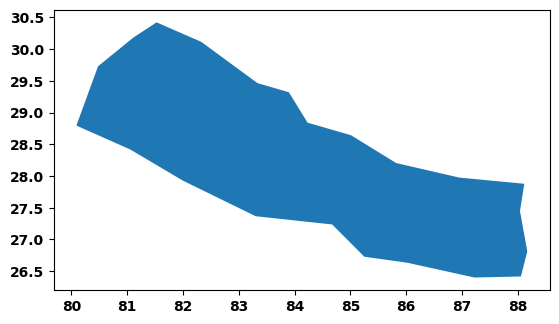

In [17]:
# Yeah. The map is not accurate. Nonetheless, this is enough for us to perform gridding

area.plot()

In [18]:
# Get a list of regions in the area polygon and find the largest one
country_regions = area.geometry.explode().tolist()
max_region = max(country_regions, key=lambda a: a.area)
g_country = max_region

# Get the bounding box of the area polygon
xmin, ymin, xmax, ymax = area.total_bounds

# Define the dimensions of each grid cell
cell_width  = 0.1
cell_height = 0.1

# Create an empty list to store the grid cells
grid_cells = []

# Iterate over the x and y coordinates of the bounding box of the area polygon
# and create a rectangular grid cell for each coordinate pair
for x0 in tqdm(np.arange(xmin, xmax+cell_width, cell_width )):
    for y0 in np.arange(ymin, ymax+cell_height, cell_height):
        x1 = x0-cell_width
        y1 = y0+cell_height
        new_cell = shapely.geometry.box(x0, y0, x1, y1)
        
        # Check if the grid cell intersects with the largest region of the area polygon
        if new_cell.intersects(g_country):
            grid_cells.append(new_cell)
            
# Create a new GeoDataFrame from the list of grid cells
fishnet_x = gpd.GeoDataFrame({'geometry':grid_cells}).set_geometry('geometry').set_crs('EPSG:4326')

# Use the overlay() method to obtain the intersection between the grid cells and the area polygon
# and keep only the resulting polygons
fishnet_x = gpd.overlay(fishnet_x, area, how = 'intersection')[['geometry']]

  0%|          | 0/82 [00:00<?, ?it/s]

<AxesSubplot: >

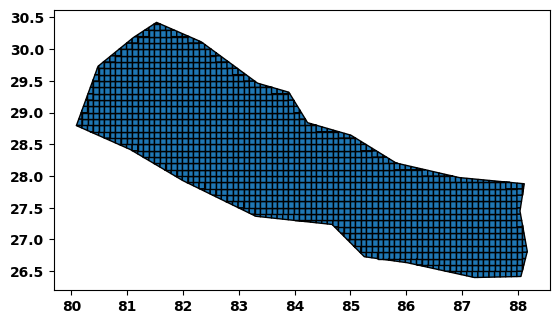

In [19]:
ax = plt.subplot()

fishnet_x.geometry.plot(edgecolor = 'black', ax = ax)

<b> You can further optimize the code above. To only select he grid areas' that intersect with the actual map, you could apply multithreading to compute the intersected grids. You could look into Dask Geopandas. Same method imported from this library will do the respective task parallely.